In [ ]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements()

In [1]:
# hide
from utils import *
setup_chapter()

Using transformers v4.23.0
Using datasets v2.18.0


# Making Transformers Efficient in Production

<img alt="Scaling BERT at Roblox" caption="How Roblox scaled BERT with knowledge distillation, dynamic padding, and weight quantization (photo courtesy of Roblox employees Quoc N. Le and Kip Kaehler)" src="images/chapter08_roblox.png" id="roblox"/>

## Intent Detection as a Case Study

<img alt="Out of Scope Query" width="400" caption="Three exchanges between a human (right) and a text-based assistant (left) for personal finance (courtesy of Stefan Larson et al.)" src="images/chapter08_oos.png" id="oos"/> 

In [2]:
#hide_output
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

In [3]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in 
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490036606788635}]

## Creating a Performance Benchmark

In [4]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        
    def compute_accuracy(self):
        # We'll define this later
        pass    

    def compute_size(self):
        # We'll define this later
        pass

    def time_pipeline(self):
        # We'll define this later
        pass
    
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [5]:
#hide_output
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

In [6]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [7]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [8]:
#hide_output
from datasets import load_metric 

accuracy_score = load_metric("accuracy")

/tmp/ipykernel_70196/3485057481.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")


/home/rohara/anaconda3/envs/hf_book_8/lib/python3.11/site-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [9]:
def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [10]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

In [11]:
import torch
from pathlib import Path

def compute_size(self):
    """This overrides the PerformanceBenchmark.compute_size() method"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # Calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

In [12]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 17.520
Latency (ms) - 14.374
Latency (ms) - 13.962


In [13]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """This overrides the PerformanceBenchmark.time_pipeline() method"""
    latencies = []
    # Warmup
    for _ in range(10):
        _ = self.pipeline(query)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [14]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.15


Average latency (ms) - 9.69 +\- 0.42
Accuracy on test set - 0.867


## Making Models Smaller via Knowledge Distillation

### Knowledge Distillation for Fine-Tuning

<img alt="Soft Probabilities" caption="Comparison of a hard label that is one-hot encoded (left), softmax probabilities (middle), and softened class probabilities (right)" src="images/chapter08_soft-probs.png" id="soft-probs"/> 

<img alt="Knowledge distillation" caption="The knowledge distillation process" src="images/chapter08_kd.png" id="kd"/> 

### Knowledge Distillation for Pretraining

### Creating a Knowledge Distillation Trainer

In [15]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [16]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

### Choosing a Good Student Initialization

In [17]:
#hide_output
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

In [18]:
# from huggingface_hub import notebook_login

# notebook_login()

In [19]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [20]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy = "epoch", 
    num_train_epochs=5, learning_rate=2e-5, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01, 
    push_to_hub=False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [21]:
#hide
student_training_args.logging_steps = len(clinc_enc['train']) // batch_size
student_training_args.disable_tqdm = False
student_training_args.save_steps = 1e9
student_training_args.log_level = "info"

In [22]:
#hide
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [23]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [24]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels, 
                                   id2label=id2label, label2id=label2id))

In [25]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [26]:
#hide_output
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [27]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

loading weights file pytorch_model.bin from cache at /home/rohara/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Dis

Epoch,Training Loss,Validation Loss,Accuracy
1,4.293900,3.286117,0.738065
2,2.631800,1.875572,0.838710
3,1.546400,1.153754,0.899355
4,1.009500,0.852605,0.913226
5,0.793400,0.769671,0.920968


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1590, training_loss=2.0511056813054114, metrics={'train_runtime': 97.7522, 'train_samples_per_second': 780.033, 'train_steps_per_second': 16.266, 'total_flos': 413896353421488.0, 'train_loss': 2.0511056813054114, 'epoch': 5.0})

In [28]:
#hide_output
# distilbert_trainer.push_to_hub("Training completed!")

In [29]:
#hide_output
finetuned_ckpt = "transformersbook/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

loading configuration file config.json from cache at /home/rohara/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-finetuned-clinc/snapshots/0993da273a157b79a93c71901ed99fb71b861b02/config.json
Model config DistilBertConfig {
  "_name_or_path": "transformersbook/distilbert-base-uncased-finetuned-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
    "15": "what_are_your_hobbies",
    "16": "order",
    "17": "jump_start",
    "18": "schedule_meet

In [30]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 5.13 +\- 0.21
Accuracy on test set - 0.858


/tmp/ipykernel_70196/1325496988.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


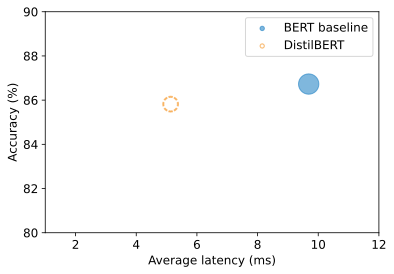

In [31]:
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        alpha=0.5, s=df_opt["size_mb"], label=idx, 
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
            
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()
    
plot_metrics(perf_metrics, optim_type)

### Finding Good Hyperparameters with Optuna

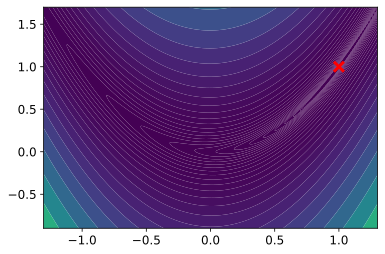

In [32]:
#hide_input
#id banana-function
#alt A banana plot
#caption Plot of the Rosenbrock function of two variables 
import matplotlib.pyplot as plt
import numpy as np

def f(x, y):
    return (1-x)**2+100*(y-x**2)**2
    
X, Y = np.meshgrid(np.linspace(-2, 2, 250), np.linspace(-1, 3, 250))
Z = f(X,Y)
_, ax = plt.subplots()
ax.plot([1], [1], 'x', mew=3, markersize=10, color="red")
ax.contourf(X, Y, Z, np.logspace(-1, 3, 30), cmap='viridis', extend="both")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.9, 1.7)
plt.show()

In [33]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [34]:
#hide_output
import optuna 

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2024-04-11 10:35:22,137] A new study created in memory with name: no-name-475337f8-03ac-412e-92cc-2bd5d3062cc1
[I 2024-04-11 10:35:22,139] Trial 0 finished with value: 529.8240974040809 and parameters: {'x': 1.5633419400395518, 'y': 0.1429366693887406}. Best is trial 0 with value: 529.8240974040809.
[I 2024-04-11 10:35:22,139] Trial 1 finished with value: 27.101389538557243 and parameters: {'x': 0.42788773439626127, 'y': -0.33434881809440054}. Best is trial 1 with value: 27.101389538557243.
[I 2024-04-11 10:35:22,140] Trial 2 finished with value: 27.50015864955575 and parameters: {'x': -1.3364574813041292, 'y': 1.316638833128526}. Best is trial 1 with value: 27.101389538557243.
[I 2024-04-11 10:35:22,140] Trial 3 finished with value: 2.0568802880311368 and parameters: {'x': 0.03851909623894789, 'y': 0.10789963874479236}. Best is trial 3 with value: 2.0568802880311368.
[I 2024-04-11 10:35:22,141] Trial 4 finished with value: 62.60983408882407 and parameters: {'x': -1.5381371515117537

[I 2024-04-11 10:35:22,199] Trial 23 finished with value: 17.809026010466006 and parameters: {'x': -0.8701847522762405, 'y': 1.135526076193826}. Best is trial 18 with value: 0.23388652812588479.
[I 2024-04-11 10:35:22,202] Trial 24 finished with value: 8.246002516532442 and parameters: {'x': 0.16247316228986974, 'y': 0.3010709948322233}. Best is trial 18 with value: 0.23388652812588479.
[I 2024-04-11 10:35:22,206] Trial 25 finished with value: 11.412220036858976 and parameters: {'x': 0.156827454109724, 'y': -0.3025332605468718}. Best is trial 18 with value: 0.23388652812588479.
[I 2024-04-11 10:35:22,209] Trial 26 finished with value: 4.775259999077901 and parameters: {'x': 0.6878632909861129, 'y': 0.25687297493569716}. Best is trial 18 with value: 0.23388652812588479.
[I 2024-04-11 10:35:22,213] Trial 27 finished with value: 13.850536266879416 and parameters: {'x': 0.6284725312893887, 'y': 0.0246737446580636}. Best is trial 18 with value: 0.23388652812588479.
[I 2024-04-11 10:35:22,21

In [35]:
study.best_params

{'x': 0.9589120205631904, 'y': 0.9176357277577757}

In [36]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

In [37]:
#hide_output
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space)

[I 2024-04-11 10:35:27,947] A new study created in memory with name: no-name-65ca9c08-12d2-43c8-a6d1-b338ca973537
Trial: {'num_train_epochs': 10, 'alpha': 0.09101598085490437, 'temperature': 12}
loading weights file pytorch_model.bin from cache at /home/rohara/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassif

Epoch,Training Loss,Validation Loss,Accuracy
1,0.395200,0.200118,0.602903
2,0.166900,0.095935,0.836774
3,0.102200,0.063411,0.890000
4,0.076000,0.047533,0.905806
5,0.062000,0.039018,0.915806
6,0.054000,0.034164,0.922581
7,0.048800,0.031008,0.923548
8,0.045400,0.029023,0.926129
9,0.043200,0.027913,0.924194
10,0.042300,0.027569,0.925161


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2024-04-11 10:38:47,176] Trial 0 finished with value: 0.9251612903225807 and parameters: {'num_train_epochs': 10, 'alpha': 0.09101598085490437, 'temperature': 12}. Best is trial 0 with value: 0.9251612

Epoch,Training Loss,Validation Loss,Accuracy
1,0.389800,0.200641,0.589677
2,0.169000,0.100036,0.828065
3,0.106700,0.068445,0.880645
4,0.081900,0.053334,0.899355
5,0.069100,0.045613,0.909032
6,0.062600,0.041895,0.914194
7,0.059200,0.040691,0.914194


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2024-04-11 10:41:07,215] Trial 1 finished with value: 0.9141935483870968 and parameters: {'num_train_epochs': 7, 'alpha': 0.7312931137694986, 'temperature': 15}. Best is trial 0 with value: 0.9251612903225807.
Trial: {'num_train_epochs': 5, 'alpha': 0.05089068434784849, 'temperature': 20}
loading weights file pytorch_model.bin from cache at /home/rohara/.cache/huggingface/hub/models--distilbert-base-uncased/sna

Epoch,Training Loss,Validation Loss,Accuracy
1,0.385500,0.202764,0.570000
2,0.173100,0.106425,0.809032
3,0.114200,0.076395,0.871935
4,0.092200,0.064402,0.885161
5,0.083100,0.060693,0.895161


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2024-04-11 10:42:47,141] Trial 2 finished with value: 0.8951612903225806 and parameters: {'num_train_epochs': 5, 'alpha': 0.05089068434784849, 'temperature': 20}. Best is trial 0 with value: 0.9251612903225807.
Trial: {'num_train_epochs': 9, 'alpha': 0.6162455321230428, 'temperature': 7}
loading weights file pytorch_model.bin from cache at /home/rohara/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used

Epoch,Training Loss,Validation Loss,Accuracy
1,0.425300,0.216671,0.616452
2,0.179700,0.102161,0.844194
3,0.108600,0.066187,0.890000
4,0.080100,0.049301,0.904839
5,0.065200,0.040455,0.917097
6,0.057000,0.035579,0.920645
7,0.051900,0.032546,0.921935
8,0.048800,0.030948,0.923548
9,0.047100,0.030463,0.923226


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2024-04-11 10:45:46,424] Trial 3 finished with value: 0.9232258064516129 and parameters: {'num_train_epochs': 9, 'alpha': 0.6162455321230428, 'temperature': 7}. Best is trial 0 with value: 0.9251612903225807.
Trial: {'num_train_epochs': 7, 'alpha': 0.08175259807510138, 't

Epoch,Training Loss,Validation Loss,Accuracy
1,0.394300,0.203012,0.591613
2,0.170800,0.100859,0.829677
3,0.107600,0.068758,0.881613
4,0.082400,0.053497,0.898710
5,0.069500,0.045692,0.909032
6,0.062900,0.041936,0.914516
7,0.059400,0.040727,0.914516


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2024-04-11 10:48:06,187] Trial 4 finished with value: 0.9145161290322581 and parameters: {'num_train_epochs': 7, 'alpha': 0.08175259807510138, 'temperature': 13}. Best is trial 0 with value: 0.9251612903225807.
Trial: {'num_train_epochs': 7, 'alpha': 0.6351913731823315, 'temperature': 4}
loading weights file pytorch_model.bin from cache at /home/rohara/.cache/huggingface/hub/models--distilbert-base-uncased/snap

Epoch,Training Loss,Validation Loss,Accuracy
1,0.499100,0.258120,0.633871
2,0.211800,0.117761,0.836774
3,0.124100,0.073751,0.890323
4,0.090600,0.054843,0.903871
5,0.074300,0.045832,0.914839
6,0.066400,0.041645,0.919355
7,0.062400,0.040301,0.918387


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2024-04-11 10:50:27,140] Trial 5 finished with value: 0.9183870967741935 and parameters: {'num_train_epochs': 7, 'alpha': 0.6351913731823315, 'temperature': 4}. Best is trial 0 with value: 0.9251612903225807.
Trial: {'num_train_epochs': 6, 'alpha': 0.4678846973396633, 'temperature': 20}
loading weights file pytorch_model.bin from cache at /home/rohara/.cache/huggingface/hub/models--distilbert-base-uncased/snaps

Epoch,Training Loss,Validation Loss,Accuracy
1,0.384000,0.199304,0.578065


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-04-11 10:50:46,645] Trial 6 pruned. 
Trial: {'num_train_epochs': 8, 'alpha': 0.42777634311849067, 'temperature': 10}
loading weights file pytorch_model.bin from cache at /home/rohara/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassi

Epoch,Training Loss,Validation Loss,Accuracy
1,0.404100,0.206793,0.600968
2,0.172900,0.100472,0.836452
3,0.107000,0.067081,0.884516


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-04-11 10:51:47,036] Trial 7 pruned. 
Trial: {'num_train_epochs': 6, 'alpha': 0.23569207549484994, 'temperature': 16}
loading weights file pytorch_model.bin from cache at /home/rohara/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Be

Epoch,Training Loss,Validation Loss,Accuracy
1,0.389100,0.202087,0.583548


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-04-11 10:52:07,834] Trial 8 pruned. 
Trial: {'num_train_epochs': 10, 'alpha': 0.30052811338297836, 'temperature': 8}
loading weights file pytorch_model.bin from cache at /home/rohara/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassi

Epoch,Training Loss,Validation Loss,Accuracy
1,0.415200,0.210597,0.615161
2,0.174600,0.099208,0.843548
3,0.105500,0.064332,0.890645
4,0.077700,0.047736,0.906774
5,0.062900,0.038972,0.917419
6,0.054700,0.034026,0.922258
7,0.049300,0.030843,0.923871
8,0.045900,0.028844,0.926452
9,0.043700,0.027749,0.924194
10,0.042700,0.027404,0.925484


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2024-04-11 10:55:27,819] Trial 9 finished with value: 0.925483870967742 and parameters: {'num_train_epochs': 10, 'alpha': 0.30052811338297836, 'temperature': 8}. Best is trial 9 with value: 0.925483870

Epoch,Training Loss,Validation Loss,Accuracy
1,0.802200,0.407309,0.659677
2,0.308400,0.140254,0.848710
3,0.141000,0.072389,0.903871
4,0.090000,0.050923,0.914516
5,0.069500,0.041886,0.923871
6,0.060000,0.037440,0.929677
7,0.054100,0.034405,0.931290
8,0.050400,0.032785,0.930968
9,0.048100,0.031668,0.932258
10,0.047000,0.031434,0.932581


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2024-04-11 10:58:47,911] Trial 10 finished with value: 0.9325806451612904 and parameters: {'num_train_epochs': 10, 'alpha': 0.928734942817385, 'temperature': 2}. Best is trial 10 with value: 0.93258064

Epoch,Training Loss,Validation Loss,Accuracy
1,0.802200,0.407309,0.659677
2,0.308400,0.140254,0.848710
3,0.141000,0.072389,0.903871
4,0.090000,0.050923,0.914516
5,0.069500,0.041886,0.923871
6,0.060000,0.037440,0.929677
7,0.054100,0.034405,0.931290
8,0.050400,0.032785,0.930968
9,0.048100,0.031668,0.932258
10,0.047000,0.031434,0.932581


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2024-04-11 11:02:07,812] Trial 11 finished with value: 0.9325806451612904 and parameters: {'num_train_epochs': 10, 'alpha': 0.8988353489036137, 'temperature': 2}. Best is trial 10 with value: 0.9325806

Epoch,Training Loss,Validation Loss,Accuracy
1,0.803300,0.409989,0.657742
2,0.311800,0.143640,0.847742
3,0.144300,0.074497,0.902258
4,0.092600,0.052449,0.913226
5,0.071800,0.043320,0.922581
6,0.062300,0.038841,0.928387
7,0.056500,0.035925,0.929677
8,0.053100,0.034632,0.930323
9,0.051300,0.034180,0.931613


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2024-04-11 11:05:07,180] Trial 12 finished with value: 0.9316129032258065 and parameters: {'num_train_epochs': 9, 'alpha': 0.9948150667280581, 'temperature': 2}. Best is trial 10 with value: 0.9325806451612904.
Trial: {'num_train_epochs': 9, 'alpha': 0.9930596931409891, '

Epoch,Training Loss,Validation Loss,Accuracy
1,0.803300,0.409989,0.657742
2,0.311800,0.143640,0.847742
3,0.144300,0.074497,0.902258
4,0.092600,0.052449,0.913226
5,0.071800,0.043320,0.922581
6,0.062300,0.038841,0.928387
7,0.056500,0.035925,0.929677
8,0.053100,0.034632,0.930323
9,0.051300,0.034180,0.931613


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


Training completed. Do not forget to share your model on huggingface.co/models =)


[I 2024-04-11 11:08:06,245] Trial 13 finished with value: 0.9316129032258065 and parameters: {'num_train_epochs': 9, 'alpha': 0.9930596931409891, 'temperature': 2}. Best is trial 10 with value: 0.9325806451612904.
Trial: {'num_train_epochs': 10, 'alpha': 0.8120797288512632, 

Epoch,Training Loss,Validation Loss,Accuracy
1,0.459700,0.233303,0.631935
2,0.191300,0.105590,0.844839
3,0.111700,0.065872,0.892581
4,0.080400,0.047879,0.905484


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-04-11 11:09:27,032] Trial 14 pruned. 
Trial: {'num_train_epochs': 8, 'alpha': 0.8448596879355518, 'temperature': 5}
loading weights file pytorch_model.bin from cache at /home/rohara/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model traine

Epoch,Training Loss,Validation Loss,Accuracy
1,0.461100,0.236321,0.628387
2,0.194900,0.109387,0.840000


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-04-11 11:10:07,042] Trial 15 pruned. 
Trial: {'num_train_epochs': 9, 'alpha': 0.8775084398939775, 'temperature': 8}
loading weights file pytorch_model.bin from cache at /home/rohara/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- Th

Epoch,Training Loss,Validation Loss,Accuracy
1,0.415800,0.211736,0.611290


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-04-11 11:10:26,610] Trial 16 pruned. 
Trial: {'num_train_epochs': 10, 'alpha': 0.6682315221455792, 'temperature': 3}
loading weights file pytorch_model.bin from cache at /home/rohara/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassi

Epoch,Training Loss,Validation Loss,Accuracy
1,0.573500,0.290696,0.653871
2,0.231000,0.117918,0.849677
3,0.123000,0.067495,0.900645
4,0.084200,0.047722,0.911613
5,0.066100,0.038533,0.922581
6,0.057000,0.033849,0.926452
7,0.051300,0.030914,0.929677
8,0.047700,0.029122,0.927419


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-04-11 11:13:06,956] Trial 17 pruned. 
Trial: {'num_train_epochs': 8, 'alpha': 0.9130346379279325, 'temperature': 6}
loading weights file pytorch_model.bin from cache at /home/rohara/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceC

Epoch,Training Loss,Validation Loss,Accuracy
1,0.439700,0.225394,0.617742
2,0.186700,0.106199,0.839677


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-04-11 11:13:46,764] Trial 18 pruned. 
Trial: {'num_train_epochs': 10, 'alpha': 0.7353621722293064, 'temperature': 10}
loading weights file pytorch_model.bin from cache at /home/rohara/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- 

Epoch,Training Loss,Validation Loss,Accuracy
1,0.402900,0.204214,0.607742


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-04-11 11:14:07,739] Trial 19 pruned. 


In [38]:
print(best_run)

BestRun(run_id='10', objective=0.9325806451612904,
hyperparameters={'num_train_epochs': 10, 'alpha': 0.928734942817385,
'temperature': 2})


In [39]:
#hide_output
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)
    
# Define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

loading weights file pytorch_model.bin from cache at /home/rohara/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Dis

Epoch,Training Loss,Validation Loss,Accuracy
1,4.022800,3.000049,0.743871
2,2.291200,1.490628,0.865161
3,1.118700,0.751377,0.916129
4,0.563000,0.468052,0.931290
5,0.326500,0.368859,0.942581
6,0.224800,0.333123,0.942903
7,0.178100,0.318476,0.946129
8,0.155500,0.311113,0.947097
9,0.145000,0.310772,0.947419
10,0.139400,0.308849,0.947742


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


Training completed. Do not forget to share your model on huggingface.co/models =)




In [40]:
#hide_output
# distil_trainer.push_to_hub("Training complete")

### Benchmarking Our Distilled Model

In [41]:
distilled_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

loading configuration file config.json from cache at /home/rohara/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-distilled-clinc/snapshots/0bebc777ca5e752414f583b61261b102ca45c606/config.json
Model config DistilBertConfig {
  "_name_or_path": "transformersbook/distilbert-base-uncased-distilled-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
    "15": "what_are_your_hobbies",
    "16": "order",
    "17": "jump_start",
    "18": "schedule_meet

Model size (MB) - 255.88
Average latency (ms) - 5.01 +\- 0.07
Accuracy on test set - 0.868


/tmp/ipykernel_70196/1325496988.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


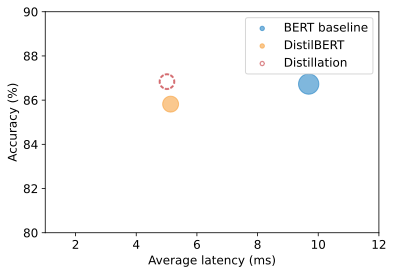

In [42]:
plot_metrics(perf_metrics, optim_type)

## Making Models Faster with Quantization

### Sidebar: A Primer on Floating-Point and Fixed-Point Numbers

### End sidebar

<img alt="Mapping floating-point numbers to 8-bit integers" width="800" caption="Quantizing floating-point numbers as unsigned 8-bit integers (courtesy of Manas Sahni)" src="images/chapter08_fp32-to-int8.png" id="fp32toint8"/>

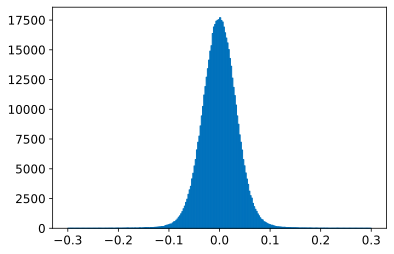

In [43]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

In [44]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [45]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [46]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

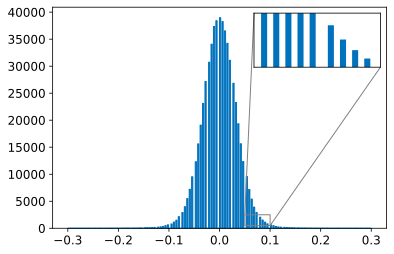

In [47]:
#hide_input
#id weight-quantization
#alt Effect of quantization on a transformer's weights
#caption Effect of quantization on a transformer's weights
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# Create histogram
fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().numpy(), 
         bins=250, range=(-0.3,0.3), edgecolor="C0");
# Create zoom inset
axins = zoomed_inset_axes(ax, 5, loc='upper right')
axins.hist(quantized_weights.dequantize().flatten().numpy(), 
         bins=250, range=(-0.3,0.3));
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

In [48]:
%%timeit 
weights @ weights

474 µs ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [49]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [50]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

105 µs ± 509 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [51]:
import sys

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

/tmp/ipykernel_70196/2099325647.py:3: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())


3.999715196311114

In [52]:
#hide_output
from torch.quantization import quantize_dynamic

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

loading file vocab.txt from cache at /home/rohara/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-distilled-clinc/snapshots/0bebc777ca5e752414f583b61261b102ca45c606/vocab.txt
loading file tokenizer.json from cache at /home/rohara/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-distilled-clinc/snapshots/0bebc777ca5e752414f583b61261b102ca45c606/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /home/rohara/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-distilled-clinc/snapshots/0bebc777ca5e752414f583b61261b102ca45c606/special_tokens_map.json
loading file tokenizer_config.json from cache at /home/rohara/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-distilled-clinc/snapshots/0bebc777ca5e752414f583b61261b102ca45c606/tokenizer_config.json
loading configuration file config.json from cache at /home/rohara/.cache/huggingface/hub

### Benchmarking Our Quantized Model

In [53]:
pipe = pipeline("text-classification", model=model_quantized, 
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.39
Average latency (ms) - 3.21 +\- 0.05
Accuracy on test set - 0.876


/tmp/ipykernel_70196/1325496988.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


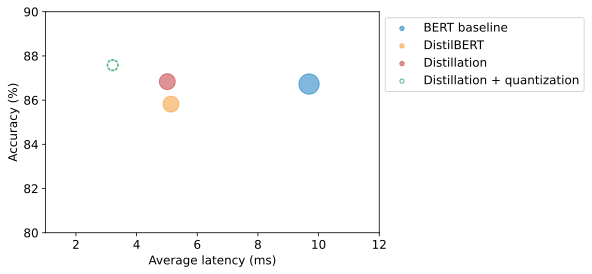

In [54]:
plot_metrics(perf_metrics, optim_type)

## Optimizing Inference with ONNX and the ONNX Runtime

<img alt="Example ONNX graph" width="500" caption="A section of the ONNX graph for BERT-base, visualized in Netron" src="images/chapter08_bert-onnx.png" id="bert-onnx"/>

<img alt="Architecture of the ONNX and ONNX Runtime ecosystem" width="500" caption="Architecture of the ONNX and ONNX Runtime ecosystem (courtesy of the ONNX Runtime team)" src="images/chapter08_onnx-ort.png" id="onnx-ort"/>

In [55]:
#hide_output
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [58]:
#hide_output
from transformers.convert_graph_to_onnx import convert

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer, 
        output=onnx_model_path, opset=12, pipeline_name="text-classification",use_external_format=False)

loading configuration file config.json from cache at /home/rohara/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-distilled-clinc/snapshots/0bebc777ca5e752414f583b61261b102ca45c606/config.json
Model config DistilBertConfig {
  "_name_or_path": "transformersbook/distilbert-base-uncased-distilled-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
    "15": "what_are_your_hobbies",
    "16": "order",
    "17": "jump_start",
    "18": "schedule_meet

ONNX opset version set to: 12
Loading pipeline (model: transformersbook/distilbert-base-uncased-distilled-clinc, tokenizer: PreTrainedTokenizerFast(name_or_path='transformersbook/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}))


All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at transformersbook/distilbert-base-uncased-distilled-clinc.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
/home/rohara/anaconda3/envs/hf_book_8/lib/python3.11/site-packages/transformers/models/distilbert/modeling_distilbert.py:213: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


Using framework PyTorch: 2.2.2+cu121
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']


In [59]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession, 
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"): 
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [60]:
onnx_model = create_model_for_provider(onnx_model_path)

In [61]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [62]:
np.argmax(logits_onnx)

61

In [63]:
clinc_enc["test"][0]["labels"]

61

In [64]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy() 
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [65]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.7848335}]

In [66]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path
        
    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [67]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.98
Average latency (ms) - 14.09 +\- 1.37
Accuracy on test set - 0.868


/tmp/ipykernel_70196/1325496988.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


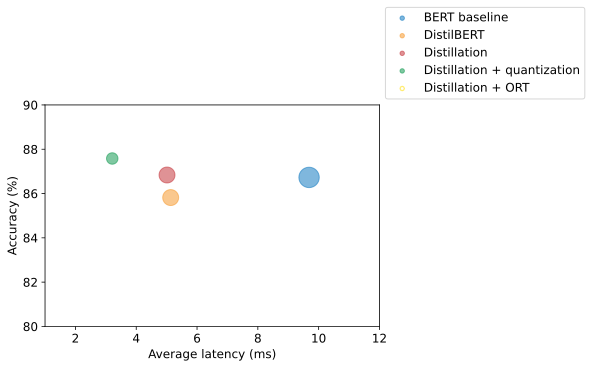

In [68]:
plot_metrics(perf_metrics, optim_type)

In [69]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

In [70]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, 
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 64.36
Average latency (ms) - 2.79 +\- 0.07
Accuracy on test set - 0.876


/tmp/ipykernel_70196/1325496988.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


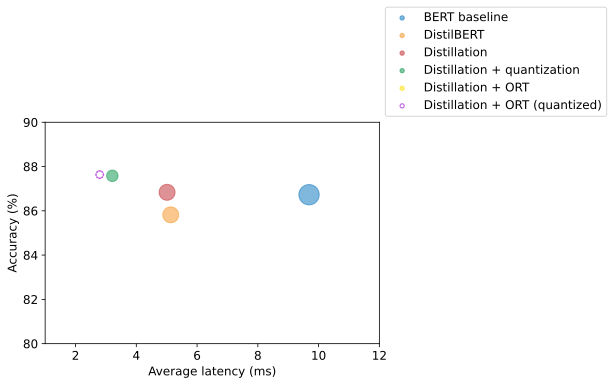

In [71]:
plot_metrics(perf_metrics, optim_type)

## Making Models Sparser with Weight Pruning

### Sparsity in Deep Neural Networks

<img alt="Network Pruning" width="500" caption="Weights and neurons before and after pruning (courtesy of Song Han)" src="images/chapter08_network-pruning.png" id="network-pruning"/> 

### Weight Pruning Methods

#### Magnitude pruning

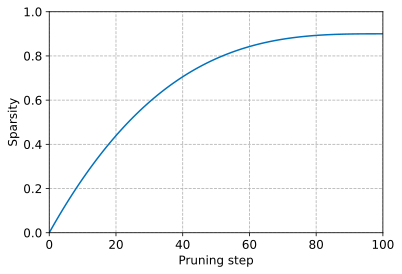

In [72]:
#hide_input
#id sparsity-scheduler
#alt Sparsity scheduler
#caption The cubic sparsity scheduler used for pruning
import numpy as np
import matplotlib.pyplot as plt

def _sparsity(t, t_0=0, dt=1, s_i=0, s_f=0.9, N=100):
    return s_f + (s_i - s_f) * (1 - (t - t_0) / (N * dt))**3

steps = np.linspace(0,100,100)
values = [_sparsity(t) for t in steps]

fig, ax = plt.subplots()
ax.plot(steps, values)
ax.set_ylim(0,1)
ax.set_xlim(0,100)
ax.set_xlabel("Pruning step")
ax.set_ylabel("Sparsity")
plt.grid(linestyle="dashed")
plt.show()

#### Movement pruning

<img alt="Magnitude vs Movement Pruning" width="700" caption="Comparison of weights removed (in gray) during magnitude pruning (left) and movement pruning (right)" src="images/chapter08_magnitude-vs-movement.png" id="magnitude-vs-movement"/> 

<img alt="Pruning Distributions" width="500" caption="Distribution of remaining weights for magnitude pruning (MaP) and movement pruning (MvP)" src="images/chapter08_pruning-dists.png" id="pruning-dists"/>

## Conclusion